# Import needed modules

In [1]:
!pip install tensorflow==2.9.0
!pip install opencv-python
!pip install opencv-python-headless
!pip install "numpy<2.0"
!pip install matplotlib seaborn scikit-learn kaggle matplotlib pandas

In [2]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras import regularizers

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

print ('modules loaded')

2025-04-08 09:40:45.851032: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


modules loaded


# Create needed functions

## Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [3]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe ( to later be fitted into the model )
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

# Split dataframe to train, valid, and test
def split_data(data_dir):
    # train dataframe
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)
    strat = df['labels']
    train_df, dummy_df = train_test_split(df,  train_size= 0.8, shuffle= True, random_state= 123, stratify= strat)

    # valid and test dataframe
    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df,  train_size= 0.5, shuffle= True, random_state= 123, stratify= strat)

    return train_df, valid_df, test_df

#### ⭐️ Function to generate images from dataframe 

In [4]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''


    # define model parameters
    img_size = (224, 224)
    channels = 3 # either BGR or Grayscale
    color = 'rgb'
    img_shape = (img_size[0], img_size[1], channels)

    # Recommended : use custom function for test data batch size, else we can use normal batch size.
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
    test_steps = ts_length // test_batch_size

    # This function which will be used in image data generator for data augmentation, it just take the image and return it again.
    def scalar(img):
        return img

    tr_gen = ImageDataGenerator(preprocessing_function= scalar, horizontal_flip= True)
    ts_gen = ImageDataGenerator(preprocessing_function= scalar)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    # Note: we will use custom test_batch_size, and make shuffle= false
    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [5]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes , images to be displayed
    g_dict = gen.class_indices        # defines dictionary {'class': index}
    classes = list(g_dict.keys())     # defines list of dictionary's kays (classes), classes names : string
    images, labels = next(gen)        # get a batch size samples from the generator

    # calculate number of displayed samples
    length = len(labels)        # length of batch size
    sample = min(length, 25)    # check if sample less than 25 images

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = images[i] / 255       # scales data to range (0 - 255)
        plt.imshow(image)
        index = np.argmax(labels[i])  # get image index
        class_name = classes[index]   # get class of image
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks** 
<br> 
Callbacks : Helpful functions to help optimize model training  <br> 
Examples: stop model training after specfic time, stop training if no improve in accuracy and so on.

In [16]:
class MyCallback(keras.callbacks.Callback):
    def __init__(self, model, patience, stop_patience, threshold, factor, batches, epochs, ask_epoch):
        super(MyCallback, self).__init__()
        self.model = model
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.stop_patience = stop_patience # specifies how many times to adjust lr without improvement to stop training
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs
        self.ask_epoch = ask_epoch
        self.ask_epoch_initial = ask_epoch # save this value to restore if restarting training

        # callback variables
        self.count = 0 # how many times lr has been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1   # epoch with the lowest loss
        self.initial_lr = float(tf.keras.backend.get_value(model.optimizer.lr)) # get the initial learning rate and save it
        self.highest_tracc = 0.0 # set highest training accuracy to 0 initially
        self.lowest_vloss = np.inf # set lowest validation loss to infinity initially
        self.best_weights = self.model.get_weights() # set best weights to model's initial weights
        self.initial_weights = self.model.get_weights()   # save initial weights if they have to get restored

    # Define a function that will run when train begins
    def on_train_begin(self, logs= None):
        self.ask_permission = 0  # 그냥 무조건 질문 안 하도록 설정

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format(
         'Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor', '% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()


    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set the weights of the model to the best weights
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get batch accuracy and loss
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        lr = float(tf.keras.backend.get_value(self.model.optimizer.lr)) # get the current learning rate
        current_lr = lr
        acc = logs.get('accuracy')  # get training accuracy
        v_acc = logs.get('val_accuracy')  # get validation accuracy
        loss = logs.get('loss')  # get training loss for this epoch
        v_loss = logs.get('val_loss')  # get the validation loss for this epoch

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_tracc ) * 100 / self.highest_tracc # define improvement of model progres

            if acc > self.highest_tracc: # training accuracy improved in the epoch
                self.highest_tracc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs
                # if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if the validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust the learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter because lr was adjusted
                    self.count = 0 # reset counter
                    tf.keras.backend.set_value(self.model.optimizer.lr, lr) # set the learning rate in the optimizer

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_tracc:
                    self.highest_tracc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)

        if self.stop_count > self.stop_patience - 1: # check if learning rate has been adjusted stop_count times with no improvement
            msg = f' training has been halted at epoch {epoch + 1} after {self.stop_patience} adjustments of learning rate with no improvement'
            print(msg)
            self.model.stop_training = True # stop training

#### **Function to plot history of training**

In [17]:
def plot_training(hist):
    '''
    This function take training model and plot history of accuracy and losses with the best epoch in both of them.
    '''

    # Define needed variables
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]
    
    Epochs = [i+1 for i in range(len(tr_acc))]
    
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    # Plot training history
    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()


# **Model Structure**

#### ⭐️Start Reading Dataset

In [8]:
# load dataset : 디렉토리 내에 kaggle.json 파일이 있어야 함
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d sujaykapadnis/watermelon-disease-recognition-dataset
!unzip watermelon-disease-recognition-dataset.zip -d ./data/


Dataset URL: https://www.kaggle.com/datasets/sujaykapadnis/watermelon-disease-recognition-dataset
License(s): Attribution 4.0 International (CC BY 4.0)
Archive:  watermelon-disease-recognition-dataset.zip
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4066_brightened.jpg  
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4066_flip.jpg  
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4066_scaled.jpg  
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4066_shifted.jpg  
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4066_zoomed.jpg  
  inflating: ./data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image/Anthracnose/IMG_4067_brightened.jpg  
  inflating: ./data/Watermelon Disease

In [9]:
import os

base_dir = '/home/nanopore/바탕화면/hajung/watermelon-disease/data'
print("하위 폴더 목록:", os.listdir(base_dir))
inner_dir = os.path.join(base_dir, 'Watermelon Disease Recognition Dataset')
print("그 안 폴더 목록:", os.listdir(inner_dir))

하위 폴더 목록: ['Watermelon Disease Recognition Dataset']
그 안 폴더 목록: ['Augmented Image', 'Original Image']


In [20]:
data_dir = '/home/nanopore/바탕화면/hajung/watermelon-disease/data/Watermelon Disease Recognition Dataset/Augmented Image/Augmented_Image' # 터미널에서 ls ./data로 경로 확인

import os

print("Classes:", os.listdir(data_dir))  # 여기에 클래스 폴더들이 나와야 해

for cls in os.listdir(data_dir):
    cls_path = os.path.join(data_dir, cls)
    if os.path.isdir(cls_path):
        print(f"{cls}: {len(os.listdir(cls_path))} images")

try:
    # Get splitted data
    train_df, valid_df, test_df = split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except Exception as e:
    print(f'Error: {e}')

Classes: ['Healthy', 'Anthracnose', 'Mosaic_Virus', 'Downy_Mildew']
Healthy: 1025 images
Anthracnose: 775 images
Mosaic_Virus: 2075 images
Downy_Mildew: 1900 images
Found 4620 validated image filenames belonging to 4 classes.
Found 577 validated image filenames belonging to 4 classes.
Found 578 validated image filenames belonging to 4 classes.


#### **Display Image Sample**

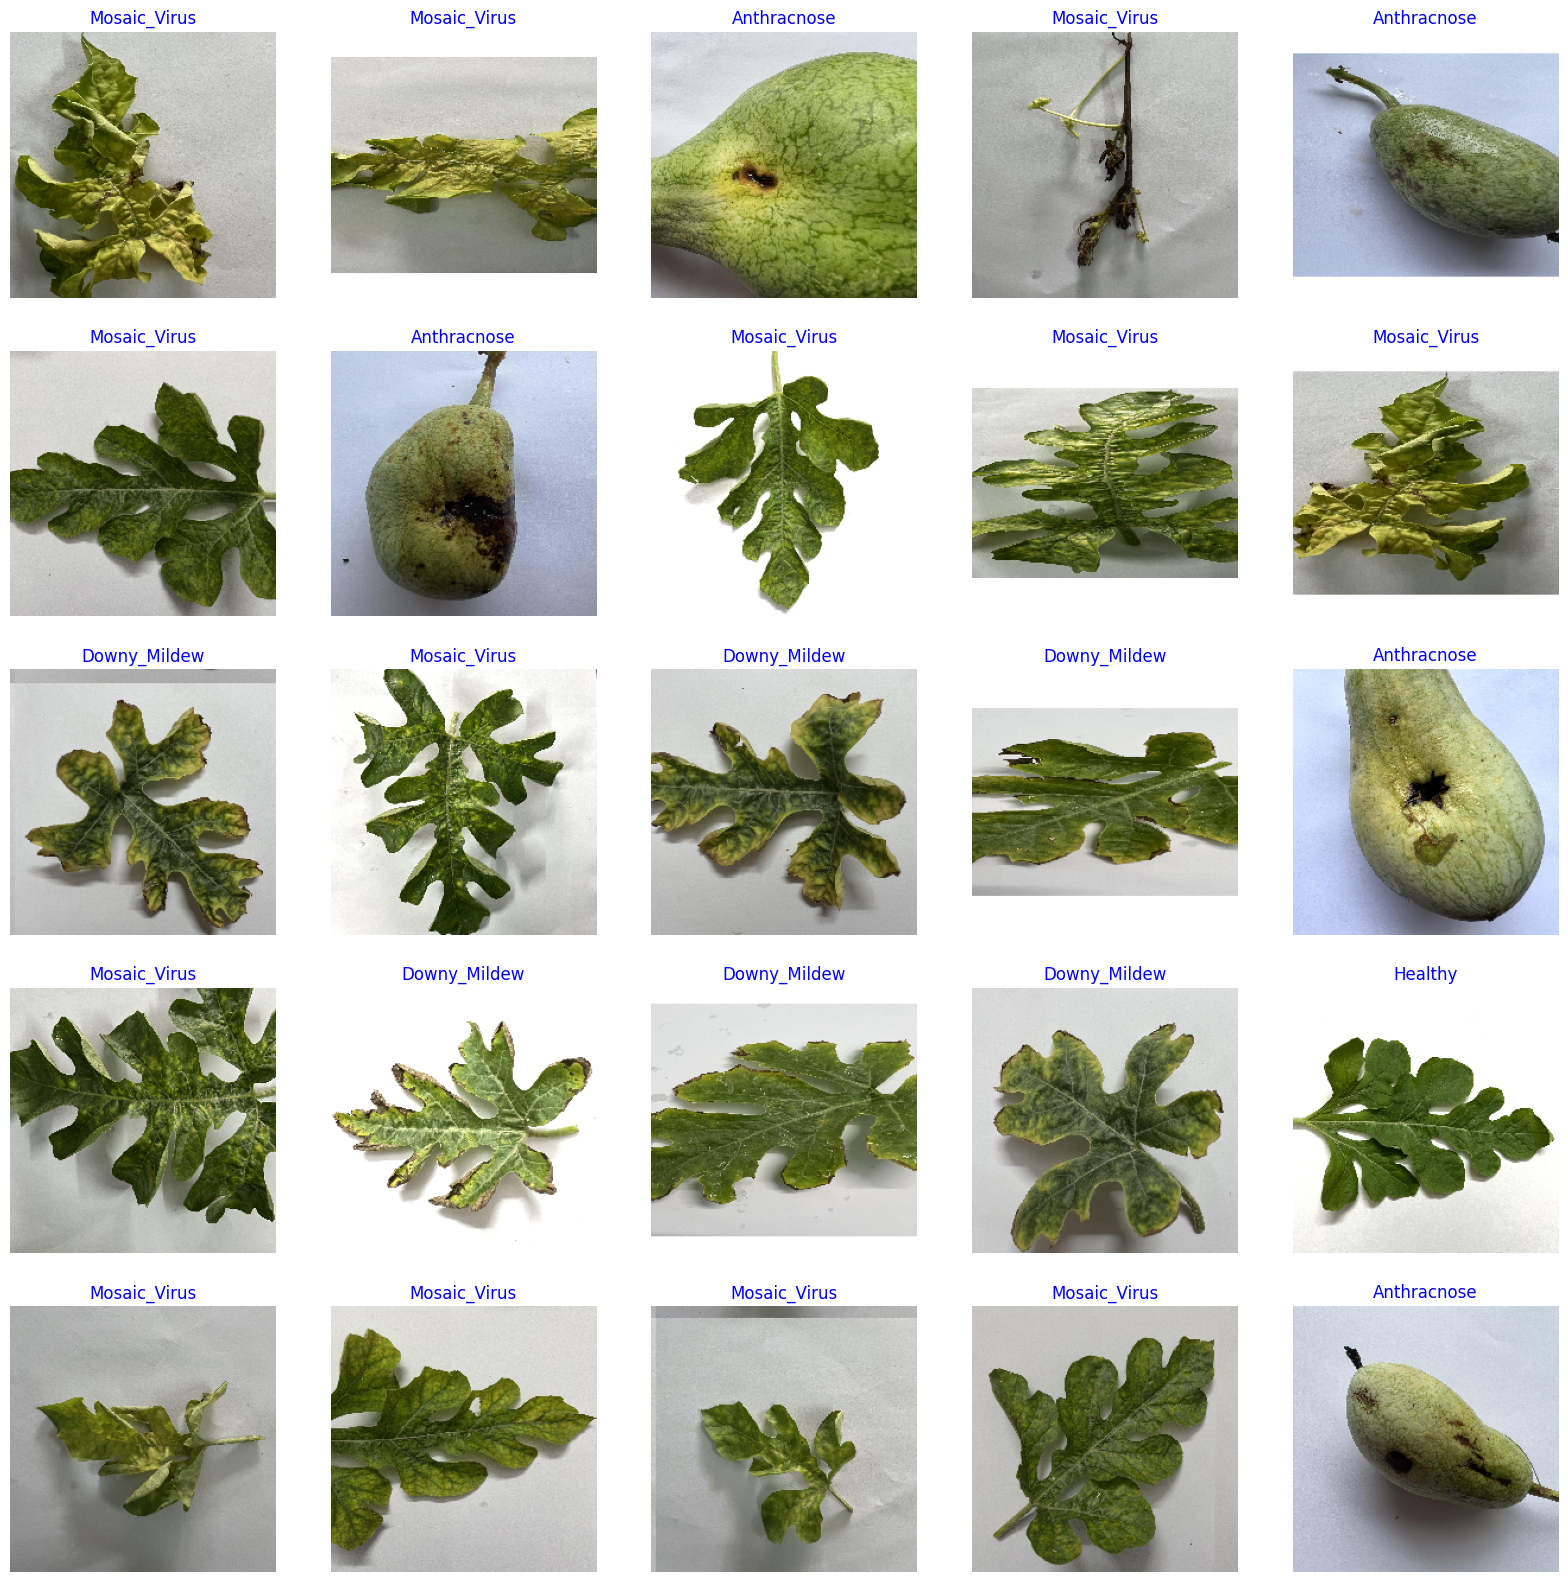

In [11]:
show_images(train_gen)

#### **Generic Model Creation**

In [21]:
# Create Model Structure
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = len(list(train_gen.class_indices.keys())) # to define number of classes in dense layer

# create pre-trained model (you can built on pretrained model such as :  efficientnet, VGG , Resnet )
# we will use efficientnetb3 from EfficientNet family.
base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top= False, weights= "imagenet", input_shape= img_shape, pooling= 'max')

model = Sequential([
    base_model,
    BatchNormalization(axis= -1, momentum= 0.99, epsilon= 0.001),
    Dense(256, kernel_regularizer= regularizers.l2(l= 0.016), activity_regularizer= regularizers.l1(0.006),
                bias_regularizer= regularizers.l1(0.006), activation= 'relu'),
    Dropout(rate= 0.45, seed= 123),
    Dense(class_count, activation= 'softmax')
])

model.compile(Adamax(learning_rate= 0.001), loss= 'categorical_crossentropy', metrics= ['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional)  (None, 1536)             10783535  
                                                                 
 batch_normalization_1 (Batc  (None, 1536)             6144      
 hNormalization)                                                 
                                                                 
 dense_2 (Dense)             (None, 256)               393472    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 1028      
                                                                 
Total params: 11,184,179
Trainable params: 11,093,804
Non-trainable params: 90,375
_____________________________________

#### ⭐️ Set Callback Parameters

In [22]:
batch_size = 40   # set batch size for training
epochs = 40   # number of all epochs in training
patience = 1   #number of epochs to wait to adjust lr if monitored value does not improve
stop_patience = 3   # number of epochs to wait before stopping training if monitored value does not improve
threshold = 0.9   # if train accuracy is < threshold adjust monitor accuracy, else monitor validation loss
factor = 0.5   # factor to reduce lr by
ask_epoch = 5   # number of epochs to run before asking if you want to halt training
batches = int(np.ceil(len(train_gen.labels) / batch_size))    # number of training batch to run per epoch

callbacks = [MyCallback(model= model, patience= patience, stop_patience= stop_patience, threshold= threshold,
            factor= factor, batches= batches, epochs= epochs, ask_epoch= ask_epoch )]

#### **Train model**

In [23]:
history = model.fit(x= train_gen, epochs= epochs, verbose= 0, callbacks= callbacks,
                    validation_data= valid_gen, validation_steps= None, shuffle= False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /40     6.187   95.909   4.59494  99.307   0.00100  0.00100  val_loss     0.00    356.35 
 2 /40     3.447   99.762   2.66290  100.000  0.00100  0.00100  val_loss    42.05    349.55 
 3 /40     2.116   99.827   1.63591  100.000  0.00100  0.00100  val_loss    38.57    349.88 
 4 /40     1.331   99.892   1.02898  100.000  0.00100  0.00100  val_loss    37.10    347.78 
 5 /40     0.857   99.913   0.66419  100.000  0.00100  0.00100  val_loss    35.45    348.53 
 6 /40     0.569   99.957   0.44792  100.000  0.00100  0.00100  val_loss    32.56    353.03 
 7 /40     0.395   99.957   0.30631  100.000  0.00100  0.00100  val_loss    31.61    347.51 
 8 /40     0.291   99.913   0.23097  100.000  0.00100  0.00100  val_loss    24.60    353.26 
 9 /40     0.229   99.892   0.18433  100.000  0.00100  0.00100  val_loss    20.19    349.15 
10 /40     0.192   99.913   0.15199  100.000  0.00100  0.00100  val_los

#### **Display model performance**

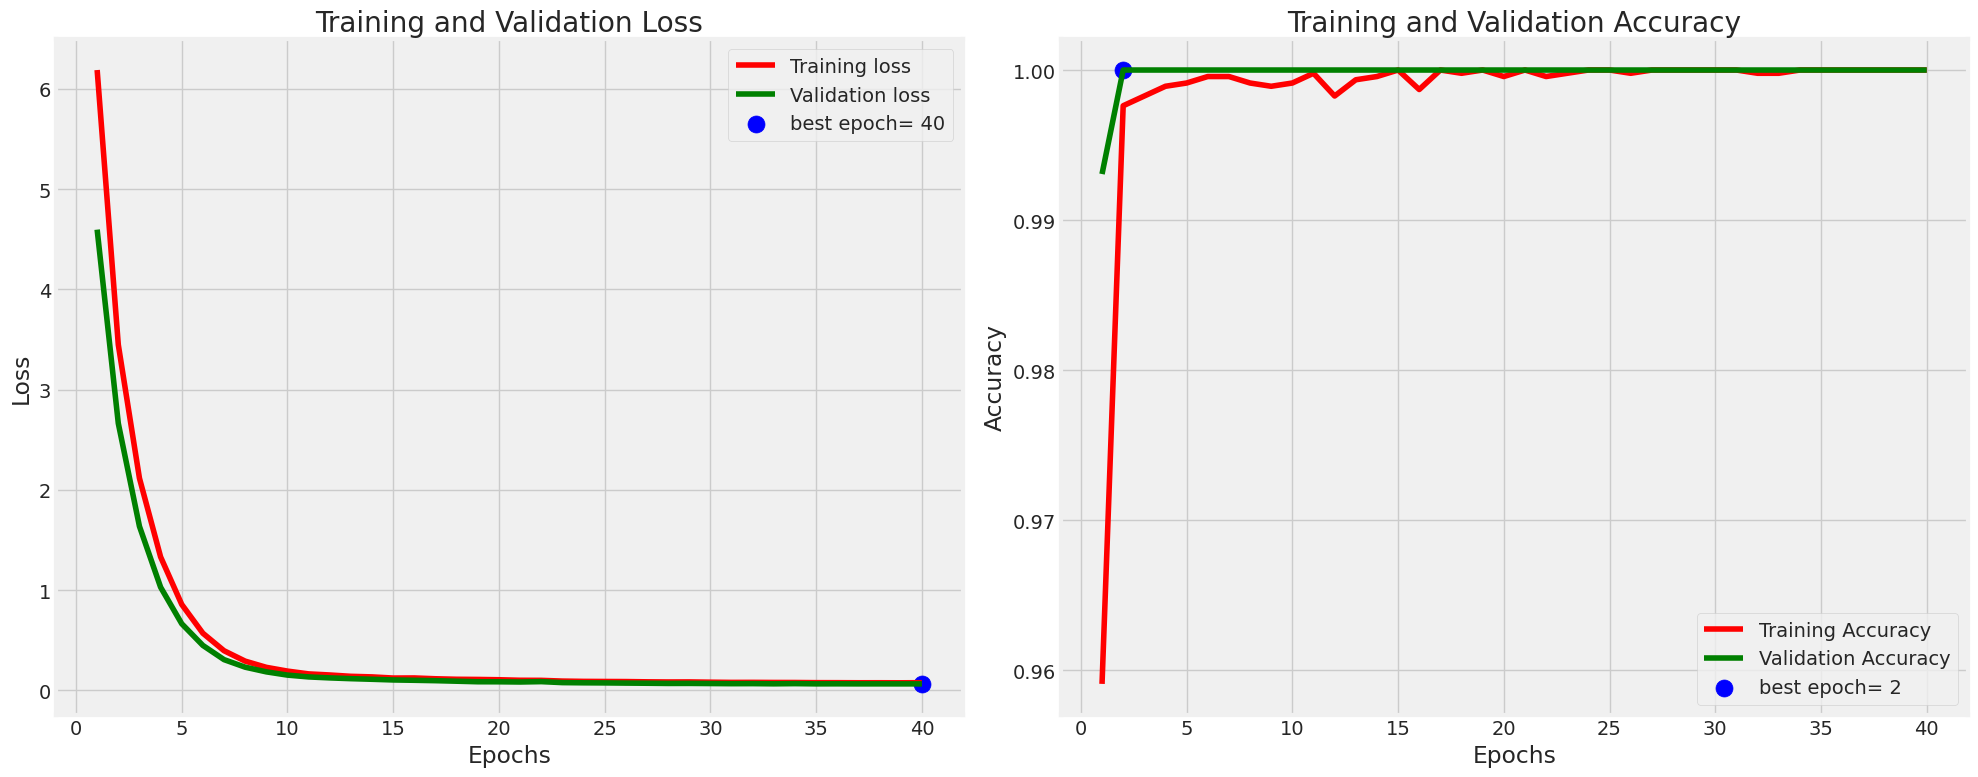

In [24]:
plot_training(history)

#### ⭐️ Model save at file

In [25]:
import os
import json
import datetime
import pandas as pd  

# 예시 이름 구성 방식: 모델이름_데이터셋_날짜.json
base_name = 'efficient_watermelonAug_250408'
filename = f'{base_name}.json'
save_dir = f'results/{base_name}'

with open(filename, 'w') as f:
    json.dump(history.history, f)

# 저장 경로 생성
os.makedirs(save_dir, exist_ok=True)

# 하이퍼파라미터 자동 수집 및 저장
config = {
    'model_name': 'model name', # 설정
    'dataset': 'dataset name', # 설정
    'epochs': len(history.history.get('loss', [])),
    'batch_size': getattr(train_gen, 'batch_size', 'unknown'),
    'steps_per_epoch': getattr(train_gen, '__len__', lambda: 'unknown')(),
    'validation_steps': getattr(valid_gen, '__len__', lambda: 'unknown')(),
    'callbacks': [cb.__class__.__name__ for cb in callbacks],
    'optimizer': type(model.optimizer).__name__ if hasattr(model, 'optimizer') else 'unknown',
    'learning_rate': float(tf.keras.backend.get_value(model.optimizer.learning_rate)) if hasattr(model.optimizer, 'learning_rate') else 'unknown',
    'loss_function': model.loss if hasattr(model, 'loss') else 'unknown',
    'metrics': model.metrics_names if hasattr(model, 'metrics_names') else 'unknown'
}
with open(os.path.join(save_dir, 'config.json'), 'w') as f:
    json.dump(config, f, indent=4)

# ✅ class_info 저장 (CSV + JSON)
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = [img_size[0]] * len(class_dict)
width = [img_size[1]] * len(class_dict)

df = pd.DataFrame({
    'class_index': list(class_dict.values()),
    'class': list(class_dict.keys()),
    'height': height,
    'width': width
})
df.to_csv(os.path.join(save_dir, 'class_info.csv'), index=False)

class_info_list = [
    {'class': cls, 'index': idx, 'height': img_size[0], 'width': img_size[1]}
    for cls, idx in class_dict.items()
]
with open(os.path.join(save_dir, 'class_info.json'), 'w') as f:
    json.dump(class_info_list, f, indent=4)

# 모델 구조 저장
model_json = model.to_json()
with open(os.path.join(save_dir, 'model_structure.json'), 'w') as f:
    f.write(model_json)

# 모델 가중치 저장
model.save_weights(os.path.join(save_dir, 'model_weights.h5'))

print(f'✅ 실험 결과 저장 완료! 폴더 경로: {save_dir}')


✅ 실험 결과 저장 완료! 폴더 경로: results/efficient_watermelonAug_250408


# **Evaluate model**

In [26]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

17/17 [==============================] - 17s 968ms/step - loss: 0.0643 - accuracy: 1.0000
Train Loss:  0.06428752839565277
Train Accuracy:  1.0
--------------------
Validation Loss:  0.06435564905405045
Validation Accuracy:  1.0
--------------------
Test Loss:  0.06430335342884064
Test Accuracy:  1.0


# **Get Predictions**

In [27]:
preds = model.predict_generator(test_gen)
y_pred = np.argmax(preds, axis=1)
print(y_pred)

[3 1 1 0 3 0 3 1 3 2 3 1 3 0 3 3 0 2 2 3 1 1 3 1 3 1 3 1 2 1 1 3 1 1 1 0 3
 3 3 0 3 2 3 1 2 3 3 2 2 3 1 3 3 1 1 0 3 3 1 3 0 3 3 2 0 3 1 1 2 3 3 3 0 3
 2 1 1 2 2 1 3 2 3 3 3 2 3 1 3 3 3 1 3 3 2 0 3 3 3 3 1 1 1 3 1 3 3 1 1 3 3
 1 3 1 1 2 1 2 2 2 1 3 3 1 1 2 2 3 3 1 2 1 0 1 3 3 3 3 1 1 0 1 0 1 1 1 3 0
 1 2 1 3 2 0 2 3 3 2 2 1 3 0 0 3 2 3 0 1 1 0 3 2 1 1 1 1 2 3 1 2 1 3 1 2 2
 3 2 1 3 3 0 1 3 1 3 3 1 0 1 3 3 2 3 1 1 1 1 1 3 0 3 3 1 1 0 0 0 3 2 0 3 3
 1 2 3 1 3 0 1 1 2 3 3 1 2 1 3 3 0 1 1 2 1 0 3 0 1 2 3 1 0 1 0 3 2 3 3 3 1
 3 1 1 3 0 2 1 3 1 1 1 3 3 3 0 3 1 2 2 3 1 3 2 3 3 2 3 2 1 1 0 3 0 3 1 0 2
 1 3 3 2 1 3 2 1 0 1 2 1 2 3 1 2 3 1 1 3 1 1 3 1 0 0 1 1 0 1 1 3 3 2 2 2 1
 1 3 3 0 1 3 2 1 1 3 3 3 3 3 1 1 3 1 3 1 0 3 2 3 1 3 3 1 1 3 3 2 1 1 2 2 0
 3 1 3 3 1 1 0 1 2 2 3 3 3 1 3 1 2 3 2 1 1 3 2 3 1 1 2 3 2 3 0 3 2 2 2 2 1
 1 3 3 3 0 2 2 3 3 3 3 0 0 3 1 2 1 2 0 1 0 1 1 1 3 3 0 1 3 1 3 2 0 3 0 1 0
 3 1 1 0 3 1 2 1 1 0 1 3 1 3 2 2 3 2 1 3 2 1 0 0 0 1 3 3 3 1 1 0 3 3 1 3 2
 3 3 3 3 3 3 0 0 1 1 3 3 

#### **Confusion Matrics and Classification Report**

In [28]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

              precision    recall  f1-score   support

 Anthracnose       1.00      1.00      1.00        77
Downy_Mildew       1.00      1.00      1.00       190
     Healthy       1.00      1.00      1.00       103
Mosaic_Virus       1.00      1.00      1.00       208

    accuracy                           1.00       578
   macro avg       1.00      1.00      1.00       578
weighted avg       1.00      1.00      1.00       578



## **Thank You..**
If you find this notebook is good enough, please upvote it..